In [1]:
PROJECT=!gcloud config get-value project
PROJECT=PROJECT[0]
BUCKET = PROJECT + '-dsongcp'
import os
os.environ['BUCKET'] = PROJECT + '-dsongcp'

In [2]:
PROJECT

'homeworks-402019'

In [3]:
BUCKET

'homeworks-402019-dsongcp'

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext('local', 'logistic')
spark = SparkSession \
    .builder \
    .appName("Logistic regression w/ Spark ML") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/01 19:38:46 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/11/01 19:38:46 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/11/01 19:38:46 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/11/01 19:38:46 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [5]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

In [6]:
traindays = spark.read \
    .option("header", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))
traindays.createOrReplaceTempView('traindays')

In [7]:
traindays.createOrReplaceTempView('traindays')

In [8]:
spark.sql("SELECT * from traindays LIMIT 5").show()

+----------+------------+
|   FL_DATE|is_train_day|
+----------+------------+
|2015-01-01|        True|
|2015-01-02|       False|
|2015-01-03|       False|
|2015-01-04|        True|
|2015-01-05|        True|
+----------+------------+



In [9]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET)
# inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET) # FULL

In [10]:
flights = spark.read.json(inputs)
flights.createOrReplaceTempView('flights')

In [11]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True'
"""
traindata = spark.sql(trainquery)

In [12]:
print(traindata.head(2))

[Row(DEP_DELAY=-3.0, TAXI_OUT=14.0, ARR_DELAY=-16.0, DISTANCE='370.00'), Row(DEP_DELAY=24.0, TAXI_OUT=12.0, ARR_DELAY=12.0, DISTANCE='370.00')]


In [13]:
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             46439|             46422|             46355|            46936|
|   mean| 8.561769202609876|15.427685149282668|3.2853413871211306|916.0707133117437|
| stddev|30.752752455053308| 8.427384168645757| 32.98848343691196|591.9164453757172|
|    min|             -22.0|               2.0|             -77.0|          1009.00|
|    max|             711.0|             178.0|             719.0|           980.00|
+-------+------------------+------------------+------------------+-----------------+



In [14]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.dep_delay IS NOT NULL AND 
  f.arr_delay IS NOT NULL
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             46355|             46355|             46355|            46355|
|   mean| 8.539531873584295|15.421507927947363|3.2853413871211306| 917.660230827311|
| stddev|30.700034730525516|  8.41130660980497| 32.98848343691196|592.0960248192869|
|    min|             -22.0|               2.0|             -77.0|          1009.00|
|    max|             711.0|             178.0|             719.0|           980.00|
+-------+------------------+------------------+------------------+-----------------+



In [15]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.CANCELLED == 'False' AND 
  f.DIVERTED == 'False'
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             46355|             46355|             46355|            46355|
|   mean| 8.539531873584295|15.421507927947363|3.2853413871211306| 917.660230827311|
| stddev|30.700034730525516|  8.41130660980497| 32.98848343691196|592.0960248192869|
|    min|             -22.0|               2.0|             -77.0|          1009.00|
|    max|             711.0|             178.0|             719.0|           980.00|
+-------+------------------+------------------+------------------+-----------------+



In [16]:
def to_example(fields):
    return LabeledPoint(\
              float(fields['ARR_DELAY'] < 15), #ontime? \
              [ \
                  fields['DEP_DELAY'], \
                  fields['TAXI_OUT'],  \
                  fields['DISTANCE'],  \
              ])

In [17]:
examples = traindata.rdd.map(to_example)

In [18]:
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)

23/11/01 19:39:22 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/11/01 19:39:22 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [19]:
print(lrmodel.weights,lrmodel.intercept)

[-0.17926510230641074,-0.1353410840270897,0.00047781052266304745] 5.403405250989946


In [20]:
print(lrmodel.predict([6.0,12.0,594.0]))

1


In [21]:
print(lrmodel.predict([36.0,12.0,594.0]))

0


In [22]:
lrmodel.clearThreshold()
print(lrmodel.predict([6.0,12.0,594.0]))
print(lrmodel.predict([36.0,12.0,594.0]))

0.9520080900763146
0.08390675828170738


In [23]:
lrmodel.setThreshold(0.7) 
print(lrmodel.predict([6.0,12.0,594.0]))
print(lrmodel.predict([36.0,12.0,594.0]))

1
0


In [24]:
MODEL_FILE='gs://' + BUCKET + '/flights/sparkmloutput/model'
os.system('gsutil -m rm -r ' + MODEL_FILE)

Removing gs://homeworks-402019-dsongcp/flights/sparkmloutput/model/metadata/part-00000#1698867281937222...
Removing gs://homeworks-402019-dsongcp/flights/sparkmloutput/model/data/#1698867287941904...
Removing gs://homeworks-402019-dsongcp/flights/sparkmloutput/model/data/_SUCCESS#1698867288164938...
Removing gs://homeworks-402019-dsongcp/flights/sparkmloutput/model/data/part-00000-c42c2164-de7b-4d11-86c0-dd71f0234282-c000.snappy.parquet#1698867287585310...
Removing gs://homeworks-402019-dsongcp/flights/sparkmloutput/model/metadata/#1698867282325443...
Removing gs://homeworks-402019-dsongcp/flights/sparkmloutput/model/metadata/_SUCCESS#1698867282523228...
/ [6/6 objects] 100% Done                                                       
Operation completed over 6 objects.                                              


0

In [25]:
lrmodel.save(sc, MODEL_FILE)
print('{} saved'.format(MODEL_FILE))

gs://homeworks-402019-dsongcp/flights/sparkmloutput/model saved


In [26]:
lrmodel = 0
print(lrmodel)

0


In [27]:
from pyspark.mllib.classification import LogisticRegressionModel
lrmodel = LogisticRegressionModel.load(sc, MODEL_FILE)
lrmodel.setThreshold(0.7)

In [28]:
print(lrmodel.predict([36.0,12.0,594.0]))

0


In [29]:
print(lrmodel.predict([8.0,4.0,594.0]))

1


In [30]:
lrmodel.clearThreshold() # to make the model produce probabilities
print(lrmodel.predict([20, 10, 500]))

0.6689849289476673


Text(0, 0.5, 'probability of ontime arrival')

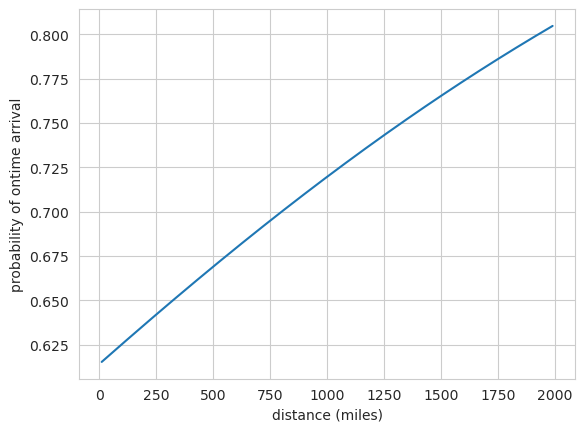

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in dist]
sns.set_style("whitegrid")
ax = plt.plot(dist, prob)
plt.xlabel('distance (miles)')
plt.ylabel('probability of ontime arrival')

Text(0, 0.5, 'probability of ontime arrival')

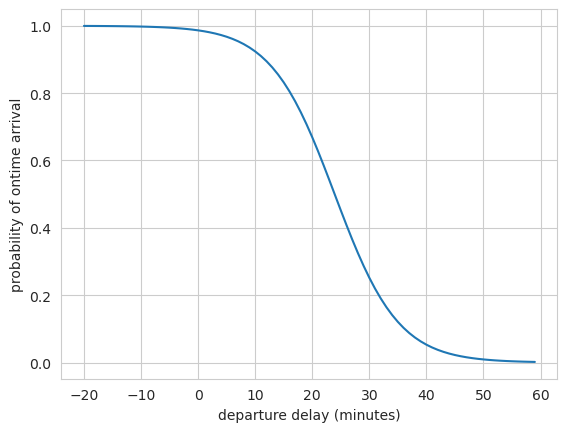

In [32]:
delay = np.arange(-20, 60, 1)
prob = [lrmodel.predict([d, 10, 500]) for d in delay]
ax = plt.plot(delay, prob)
plt.xlabel('departure delay (minutes)')
plt.ylabel('probability of ontime arrival')

In [33]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00001-*'.format(BUCKET)
flights = spark.read.json(inputs)
flights.createOrReplaceTempView('flights')

testquery = trainquery.replace("t.is_train_day == 'True'","t.is_train_day == 'False'")

In [34]:
testdata = spark.sql(testquery)
examples = testdata.rdd.map(to_example)

In [35]:
testdata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             82184|             82184|             82184|            82184|
|   mean| 8.674377007690062|15.676676725396671|3.8409179402316753|838.9512557188747|
| stddev|38.764341740364586| 8.505730543334973| 41.25995960185183|600.3088554927516|
|    min|             -35.0|               1.0|             -70.0|          1005.00|
|    max|            1576.0|             154.0|            1557.0|           998.00|
+-------+------------------+------------------+------------------+-----------------+



In [36]:
def eval(labelpred):
    ''' 
        data = (label, pred)
            data[0] = label
            data[1] = pred
    '''
    cancel = labelpred.filter(lambda data: data[1] < 0.7)
    nocancel = labelpred.filter(lambda data: data[1] >= 0.7)
    corr_cancel = cancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()
    corr_nocancel = nocancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()
    
    cancel_denom = cancel.count()
    nocancel_denom = nocancel.count()
    if cancel_denom == 0:
        cancel_denom = 1
    if nocancel_denom == 0:
        nocancel_denom = 1
    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel_denom, \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel_denom \
           }

In [37]:
lrmodel.clearThreshold() # so it returns probabilities
labelpred = examples.map(lambda p: (p.label, lrmodel.predict(p.features)))
print('All flights:')
print(eval(labelpred))

All flights:


{'total_cancel': 14689, 'correct_cancel': 0.8239498944788617, 'total_noncancel': 67495, 'correct_noncancel': 0.9556411586043411}


In [38]:
print('Flights near decision threshold:')
labelpred = labelpred.filter(lambda data: data[1] > 0.65 and data[1] < 0.75)
print(eval(labelpred))

Flights near decision threshold:


{'total_cancel': 714, 'correct_cancel': 0.3711484593837535, 'total_noncancel': 850, 'correct_noncancel': 0.6788235294117647}
